In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import random
from scipy.integrate import solve_ivp
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import pickle
import csv

layers = keras.layers


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:


# Configurations for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Constants 
g = 9.81      
L1 = 1.0     
L2 = 1.0     
m1 = 1.0     
m2 = 1.0     

# initial states for plot
y0 = [np.pi/2, 1, np.pi/2, 1]

initials = [[np.pi/2, 1, np.pi/2, 1], [np.pi/4, -1, np.pi/4, -1], [-np.pi/2, 0, np.pi/2, 0], [0.1, 2.0, 3*np.pi/4, -1.5], [np.pi, 0.5, -np.pi/2, -0.5], [-np.pi, -2.0, np.pi/3, 1.0]]
initials_lyaps = [1.40176, 1.59057, 2.28863, 2.7653, 2.8809, 2.94079]


In [4]:

# ---------------------- Signal Definitions ---------------------- #
def f_sin(t, mean, sigma):
    """Sinusoidal signal with Gaussian noise."""
    input_noise = np.random.normal(loc=mean, scale=sigma, size=len(t))
    return np.sin(2 * np.pi * t), input_noise


def f_pendulum(t, mean, sigma, init):

    """Pendulum signal with Gaussian noise."""
    
    θ1, θ2 = solve_pendulum(t, init)
    input_noise = np.random.normal(mean, sigma, size=len(t))
    if angle_choice == 1:
        return θ1, input_noise
    else:
        return θ2, input_noise

# ---------------------- Solve Double Pendulum ---------------------- #

def double_pendulum_derivs(t, y):
    """
    EOM of the double pendulum.
    """
    θ1, ω1, θ2, ω2 = y
    Δ = θ2 - θ1

    # denominators
    D1 = (m1 + m2) * L1 - m2 * L1 * np.cos(Δ)**2
    D2 = (m1 + m2) * L2 - m2 * L2 * np.cos(Δ)**2

    # first‐order angles
    dθ1 = ω1
    dθ2 = ω2

    # ω1 numerator
    num1 = (
        m2 * L1 * ω1**2 * np.sin(Δ) * np.cos(Δ)
        + m2 * g * np.sin(θ2) * np.cos(Δ)
        + m2 * L2 * ω2**2 * np.sin(Δ)
        - (m1 + m2) * g * np.sin(θ1)
    )
    dω1 = num1 / D1

    # ω2 numerator
    num2 = (
        -m2 * L2 * ω2**2 * np.sin(Δ) * np.cos(Δ)
        + (m1 + m2) * (
            g * np.sin(θ1) * np.cos(Δ)
            - L1 * ω1**2 * np.sin(Δ)
            - g * np.sin(θ2)
        )
    )
    dω2 = num2 / D2

    return [dθ1, dω1, dθ2, dω2]


def solve_pendulum(t, init):
    """
    Solve the simple and double pendulum equations of motion using solve_ivp.
    """
    if system_type == 'simple' and angle_choice == 2:
        raise ValueError("Simple pendulum has only one angle. Set angle_choice = 1.")
     
    elif system_type == 'double':
        sol = solve_ivp(double_pendulum_derivs, (t[0], t[-1]), init, t_eval=t, method='DOP853')
        θ1, ω1, θ2, ω2 = sol.y[0], sol.y[1], sol.y[2], sol.y[3]

    elif 'simple' in system_type:

        def simple_pendulum(t, y):
            θ, ω = y
            return [ω, -g / L1 * np.sin(θ)]
        
        if 'chaotic' in system_type:
            sol = solve_ivp(simple_pendulum, (t[0], t[-1]), init[:2], t_eval=t, method='DOP853')
        else:
            sol = solve_ivp(simple_pendulum, (t[0], t[-1]), [i/10 for i in init[:2]], t_eval=t, method='DOP853') # non chaotic initial condition (first two initals)
        
        θ1, ω1 = sol.y[0], sol.y[1]
        θ2 = np.zeros_like(θ1)  # dummy since there is only one angle
        ω2 = np.zeros_like(ω1)  # dummy

    else:
        raise ValueError("Invalid system type")
    
    return θ1, ω1, θ2, ω2


# ---------------------- Lyapunov Calculator ---------------------- #
def lp_numeric(k, input_noise_norm, output_noise_norm, I):
    """Estimate Lyapunov exponent for the network predictions from input/output noise norms. l here is the network layer index."""
    return np.log(output_noise_norm / input_noise_norm) / (k/2+I/2)


def lp_analytical(initial, t, end):
    """
    Estimate the largest Lyapunov exponent from two nearby initial conditions for the "exact" solution.
    """

    pert = np.random.normal(0, 0.01, size=4) # perturbed initial parameters
    
    # Integrate both trajectories
    sol1 = solve_ivp(double_pendulum_derivs, (0, end), initial, t_eval=t, method='DOP853')
    sol2 = solve_ivp(double_pendulum_derivs, (0, end), initial + pert, t_eval=t, method='DOP853')

    delta = np.linalg.norm(sol2.y - sol1.y, axis=0) # Compute the distance between the two trajectories at each time step
    delta_initial = np.linalg.norm(pert) # Initial perturbation magnitude
    lyap = np.log(delta / delta_initial) # Lyapunov exponent estimate as a function of time

    return lyap / t # return computed lyapunov per time step


def rnn_jac(Wxh, Whh, ht, xt, phiprime):
    """
    Compute the Jacobian of the RNN with respect to the hidden state ht
    :param Wxh: input-to-hidden weight matrix (U)
    :param Whh: hidden-to-hidden weight matrix (V)
    :param ht: current hidden state
    :param xt: current input
    :param phiprime: function handle for the derivative of the activation function
    :return: Jacobian matrix
    """
    ht = np.reshape(ht, [-1, 1])  # shape: (32, 1)
    xt = np.reshape(xt, [-1, 1])  # shape: (32, 1)
    # Compute the Jacobian of the RNN with respect to ht


    alpha=Wxh@xt + Whh@ht
    J=np.diag(phiprime(alpha).flatten())@Whh
    return J

def calc_LEs(x_batches, h0, RNNlayer, activation_function_prim=lambda x:np.heaviside(x,1), k_LE=1000):
    """
    Calculate the Lyapunov exponents of a batch of sequences using the QR method.
    :param x_batches: input sequences (batch_size, T, input_size)
    :param h0: initial hidden state (batch_size, hidden_size)
    :param RNNlayer: RNN layer object (e.g., tf.keras.layers.SimpleRNN)
    :param activation_function_prim: function handle to derivative of activation function used in the RNN layer
    :param k_LE: number of Lyapunov exponents to compute
    :return: Lyapunov exponents for each batch (batch_size, k_LE)
    """
    #get dimensions
    batch_size, hidden_size = h0.shape
    batch_sizeX, T, input_size = x_batches.shape
    if batch_size != batch_sizeX:
        raise ValueError("batch size of h and X not compatible")
    L = hidden_size

    #get recurrent cell
    RNNcell=RNNlayer.cell

    # Choose how many exponents to track
    k_LE = max(min(L, k_LE), 1)

    #save average Lyapunov exponent over the sequence for each batch
    lyaps_batches = np.zeros((batch_size, k_LE))
    #Loop over input sequence
    for batch in range(batch_size):
        x=x_batches[batch]
        ht=h0[batch]
        #Initialize Q
        Q = tf.eye(L)
        #keep track of average lyapunov exponents
        cum_lyaps = tf.zeros((k_LE,))

        for t in range(T):
            #Get next state ht+1 by taking a reccurent step
            xt=x[t]
            xt = tf.cast(tf.reshape(xt, [1, input_size]), tf.float32); ht = tf.cast(tf.reshape(ht, [1, L]), tf.float32); _, ht = RNNcell(xt, ht)

            #Get jacobian J
            Wxh, Whh, b = RNNlayer.get_weights()
            # Transpose to match math-style dimensions
            Wxh = Wxh.T  # Now shape (units, input_dim)
            Whh = Whh.T  # Now shape (units, units)
            J = rnn_jac(Wxh, Whh, ht, xt, activation_function_prim)
            #Get the Lyapunov exponents from qr decomposition
            Q=Q@J
            Q,R=tf.linalg.qr(Q, full_matrices=False)
            cum_lyaps += tf.math.log(tf.math.abs(tf.linalg.diag_part(R[0:k_LE, 0:k_LE])))
        lyaps_batches[batch] = cum_lyaps / T
    return lyaps_batches



# ---------------------- Data Generation ---------------------- #

def get_data_full_state(initial):
    """
    Generate training data using unperturbed dynamics, and return a unperturbed and a perturbed input version.
    Also returns the total noise vector as one array on the form [N, 2].
    """

    n = N - window_size - 1
    t = np.linspace(0, end, N)

    θ1, ω1, θ2, ω2 = solve_pendulum(t, initial)
    θ = θ1 if angle_choice == 1 else θ2
    ω = ω1 if angle_choice == 1 else ω2

    # Generate Gaussian noise for angle and angular velocity
    noise = np.random.normal(mean, sigma, size=len(t))

     # Perturbed versions
    θ_pert = θ + noise
    ω_pert = ω + noise

    # Normalize θ and ω separately using StandardScaler
    scaler_theta = StandardScaler()
    scaler_omega = StandardScaler()

    θ_scaled = scaler_theta.fit_transform(θ.reshape(-1, 1)).flatten()
    ω_scaled = scaler_omega.fit_transform(ω.reshape(-1, 1)).flatten()
    θ_pert_scaled = scaler_theta.transform(θ_pert.reshape(-1, 1)).flatten()
    ω_pert_scaled = scaler_omega.transform(ω_pert.reshape(-1, 1)).flatten()

    # Stack noise vectors for full input noise (shape: [N, 2])
    input_noise = np.stack([noise, noise], axis=1)

    # Construct training sequences
    X = np.stack([np.stack([θ_scaled[i: i + window_size], ω_scaled[i: i + window_size]], axis=1) for i in range(n)])
    X_pert = np.stack([np.stack([θ_pert_scaled[i: i + window_size], ω_pert_scaled[i: i + window_size]], axis=1) for i in range(n)])

    # labels [θ, ω]
    y = np.stack([np.array([θ_scaled[i + window_size], ω_scaled[i + window_size]]) for i in range(n)])

    # Train/test split
    split_idx = int(0.90 * n) # 90% for training, 10% for testing for computational efficiency
    return X[:split_idx], y[:split_idx], X_pert[:split_idx], X[split_idx:], y[split_idx:], X_pert[split_idx:], θ, ω, θ_pert, ω_pert, input_noise, t


def get_test_sets(initials):
    """
    Generate test sets for different initial conditions.
    """

    test_sets = []
    for initial in initials:
        _, _, _, X_test, y_test, X_pert_test, *_ = get_data_full_state(initial)
        test_sets.append((X_test, y_test, X_pert_test))

    return test_sets, X_test, y_test, X_pert_test


# ---------------------- Model ---------------------- #
class LyapunovCallback(keras.callbacks.Callback):
    """
    Custom callback to compute Lyapunov exponents after each epoch.
    """

    def __init__(self, test_sets, k, number_exponents, I):
        self.test_sets = test_sets  # list of (X_clean, y, X_pert)
        self.k = k
        self.I = I 
        self.number_exponents = number_exponents
        self.lyap_list_all = [[] for _ in test_sets]
        self.lyap_list_jac_all = [[] for _ in test_sets]
        self.lyap_list_jac_noise_all = [[] for _ in test_sets]

    def on_epoch_end(self, epoch, logs=None):
        # for set_idx, (X_clean_seq, _, X_pert_seq) in enumerate(self.test_sets): # loop over test sets
        #     lyaps = []
        #     lyaps_jac = []

        #     for i in range(len(X_clean_seq)):
        #         x_clean = X_clean_seq[i]
        #         x_pert = X_pert_seq[i]

        #         x_noise = x_pert - x_clean # noise in phase space
        #         input_noise_norm = np.linalg.norm(x_noise) / x_clean.shape[0]

        #         θ_clean_pred, ω_clean_pred = predict_k_steps(self.model, x_clean, self.k)
        #         θ_pert_pred, ω_pert_pred = predict_k_steps(self.model, x_pert, self.k)

        #         output_noise = np.stack([θ_pert_pred - θ_clean_pred, ω_pert_pred - ω_clean_pred], axis=1)
        #         output_noise_norm = np.linalg.norm(output_noise) / len(output_noise)

        #         lyap = lp_numeric(self.k, input_noise_norm, output_noise_norm, self.I)
        #         lyaps.append(lyap)


        #         # Jacobian method on a few
        #         H0 = np.zeros((1, hidden_dim))

        #         x_clean_batch = x_clean[np.newaxis, :, :] # add axis
        #         x_clean_batch_noise = x_noise[np.newaxis, :, :]
                

        #         lyap_jac = max(calc_LEs(x_clean_batch, H0, rnn_layer, tanh_prim, self.number_exponents)[0])
        #         # lyap_jac_noise = max(calc_LEs(x_clean_batch_noise, H0, rnn_layer, tanh_prim, self.number_exponents)[0])

        #         lyaps_jac.append(lyap_jac)

        #     # Store means for this test set
        #     self.lyap_list_all[set_idx].append(np.mean(lyaps))
        #     self.lyap_list_jac_all[set_idx].append(np.mean(lyaps_jac))
        #     # self.lyap_list_jac_noise_all[set_idx].append(np.mean(lyap_jac_noise))

        #     print(f" | Epoch {epoch+1} | Initial {set_idx+1}: <PLE λ> = {round(np.mean(lyaps), 4)} s⁻¹, <HSLE λ> = {round(np.mean(lyaps_jac), 4)} s⁻¹")
        pass
    
class SaveModelAndLyapCallback(keras.callbacks.Callback):
    def __init__(self, lyap_cb, model_prefix="simple_model", lyap_prefix="simple_lyap",
                 loss_log_filename="simple_losses.csv", save_dir="models"):
        super().__init__()
        self.lyap_cb = lyap_cb
        self.model_prefix = model_prefix
        self.lyap_prefix = lyap_prefix
        self.loss_log_filename = os.path.join(save_dir, loss_log_filename)
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

        # Initialize CSV with headers
        with open(self.loss_log_filename, "w", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["epoch", "train_loss", "val_loss"])

    def on_epoch_end(self, epoch, logs=None):
        epoch_idx = epoch + 1

        # # Save model
        # model_path = os.path.join(self.save_dir, f"{self.model_prefix}_epoch{epoch_idx:03d}.h5")
        # self.model.save(model_path)

        # # Save lyap_cb data
        # lyap_path = os.path.join(self.save_dir, f"{self.lyap_prefix}_epoch{epoch_idx:03d}.pkl")
        # with open(lyap_path, "wb") as f:
        #     pickle.dump({
        #         "lyap_list_all": self.lyap_cb.lyap_list_all,
        #         "lyap_list_jac_all": self.lyap_cb.lyap_list_jac_all
        #     }, f)

        # Save loss to CSV
        if logs is not None:
            train_loss = logs.get("loss", None)
            val_loss = logs.get("val_loss", None)
            with open(self.loss_log_filename, "a", newline='') as f:
                writer = csv.writer(f)
                writer.writerow([epoch_idx, train_loss, val_loss])
# ---------------------- Model ---------------------- #

def define_model():
    """Model that takes [θ, ω] sequences and predicts next [θ, ω]."""

    z0 = layers.Input(shape=[None, 2])  # time steps unspecified, 2 features
    z = layers.SimpleRNN(32, activation="tanh")(z0)
    z = layers.Dense(32, activation='relu')(z)
    z = layers.Dense(16, activation='relu')(z)
    z = layers.Dense(2)(z)

    model = keras.models.Model(inputs=z0, outputs=z)
    model.compile(loss='mse', optimizer='adam')

    return model

def train_model(callback):
    """Train model and compute Lyapunov exponent after each epoch."""

    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)  # reduce lr
    save_cb = SaveModelAndLyapCallback(lyap_cb, "_", "_", "simple_losses2.csv", "models")  # save model and Lyapunov data

    results = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1,
        callbacks=[lyap_cb, lr_scheduler, save_cb]
    )

    return results


# ---------------------- Prediction ---------------------- #
def predict_k_steps(model, input_window, k):
    """
    Rollout k-step prediction given a model and an input window.
    Returns predicted theta and omega arrays (length k).
    """
    x = input_window[np.newaxis, :, :]  # shape (1, window_size, 2)
    y_pred = np.zeros((k, 2))

    for i in range(k):
        y_pred[i] = model.predict(x, verbose=0)[0]
        x = np.roll(x, -1, axis=1)  # Shift
        x[:, -1, :] = y_pred[i]     # Append new prediction

    θ_pred, ω_pred = y_pred[:, 0], y_pred[:, 1]
    return θ_pred, ω_pred

# ---------------------- Plot ---------------------- #


def plot_training(results):
    """Plot training and validation loss."""
    plt.figure(figsize=(10, 4))
    plt.plot(results.history['loss'], label='Train Loss')
    plt.plot(results.history['val_loss'], label='Val Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (log scale)')
    plt.title('Training Progress')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()



def plot_lyapunov_time(t, lp, label):
    """
    Plot Analytical Lyapunov exponent over time.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(t, lp, label=label)
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\lambda(t)$')
    plt.title('Lyapunov Exponent Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_lyapunov_comparison_all(
    lyap_lists, lyap_jac_lists, labels, train_loss, val_loss, ylabel=r'FTLE $\lambda$ [s⁻¹]',
    legend_loc='upper left'
):
    """
    Plot LE and training/validation loss over epochs.
    legend_loc: 'upper left' or 'lower left'
    """

    x = np.arange(1, 21)  # x-axis: epochs 1 to 20

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left axis: Lyapunov exponents
    for i in range(len(labels)):
        ax1.plot(x, lyap_lists[i], marker='o', label=f'{labels[i]} (PLE)', markersize=5, linewidth=1.5)
        ax1.plot(x, lyap_jac_lists[i], marker='x', linestyle='--', label=f'{labels[i]} (HSLE)', markersize=5, linewidth=1.5)

    ax1.set_xlabel('Epoch', fontsize=24, fontweight='bold')
    ax1.set_ylabel(ylabel, fontsize=24, fontweight='bold', labelpad=18)
    ax1.set_title('Lyapunov exponents and loss during training', fontsize=26, fontweight='bold', pad=30)
    ax1.tick_params(axis='both', labelsize=22)
    ax1.grid(True)
    ax1.set_ylim(-0.5, 0.2)  # Fixed y-axis range
    ax1.set_xlim(1, 20)

    # Right axis: Training and validation loss
    ax2 = ax1.twinx()
    ax2.plot(x, train_loss, color='black', linestyle='-', label='Training loss', alpha=0.7, linewidth=1.5)
    ax2.plot(x, val_loss, color="#696969", linestyle='-', label='Validation loss', alpha=0.85, linewidth=1.5)
    ax2.set_yscale('log')
    ax2.set_ylabel('MSE loss (log scale)', fontsize=24, fontweight='bold')
    ax2.tick_params(axis='both', labelsize=22)
    ax2.set_xlim(1, 20)

    # Combine legends
    lines, labels_ = ax1.get_legend_handles_labels()
    if train_loss is not None or val_loss is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines += lines2
        labels_ += labels2
    ax1.legend(lines, labels_, loc=legend_loc, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


def plot_lyapunov_noise(lyap_jac_clean, lyap_jac_noise, labels, ylabel=r'Lyapunov exponent $\lambda$ [s⁻¹]'):
    plt.figure(figsize=(10, 6))
    
    for i in range(len(labels)):
        plt.plot(lyap_jac_clean[i], marker='o', label=f'{labels[i]} (clean)')
        plt.plot(lyap_jac_noise[i], marker='x', linestyle='--', label=f'{labels[i]} (noise)')

    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title('HSLE: clean vs noisy inputs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def scatter_plot_predictions(model, X_test, y_test, title_suffix='test set'):
    y_pred = model.predict(X_test)

    θ_true = y_test[:, 0]
    ω_true = y_test[:, 1]
    θ_pred = y_pred[:, 0]
    ω_pred = y_pred[:, 1]

    plt.figure(figsize=(8, 12))

    # Theta subplot (top)
    plt.subplot(2, 1, 1)
    plt.scatter(θ_true, θ_pred, alpha=0.5, label='Predictions')
    plt.plot([θ_true.min(), θ_true.max()], [θ_true.min(), θ_true.max()], 'r--', label='Ideal prediction')
    plt.xlabel('Normalized true θ [rad]', fontsize=18, fontweight='bold')
    plt.ylabel('Normalized predicted θ [rad]', fontsize=18, fontweight='bold')
    plt.title('Normalized angle prediction ({})'.format(title_suffix), fontsize=20, fontweight='bold')
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=14)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Omega subplot (bottom)
    plt.subplot(2, 1, 2)
    plt.scatter(ω_true, ω_pred, alpha=0.5, label='Predictions')
    plt.plot([ω_true.min(), ω_true.max()], [ω_true.min(), ω_true.max()], 'r--', label='Ideal prediction')
    plt.xlabel('Normalized true ω [rad/s]', fontsize=18, fontweight='bold')
    plt.ylabel('Normalized predicted ω [rad/s]', fontsize=18, fontweight='bold')
    plt.title('Normalized angular velocity prediction ({})'.format(title_suffix), fontsize=20, fontweight='bold')
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=14)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    plt.show()

def plot_solution_curve():
    """
    Inspection of solution curves for the simple or double pendulum.
    """
    t = np.linspace(0, 10, 1000)

    if system_type == 'simple':
        θ1, ω1, θ2, ω2 = solve_pendulum(t, [i / 10 for i in y0])
    else:
        θ1, ω1, θ2, ω2 = solve_pendulum(t, y0)

    plt.figure(figsize=(14, 8))

    # θ₁ and θ₂ subplot
    plt.subplot(2, 1, 1)
    plt.plot(t, θ1, label=r'$\theta_1(t)$', linewidth=1.5)

    if system_type == 'double':
        plt.plot(t, θ2, label=r'$\theta_2(t)$', linestyle='--', linewidth=1.5)

    plt.ylabel('Angle [rad]', fontsize=24, fontweight='bold')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=22)
    plt.grid(True)

    # ω₁ and ω₂ subplot
    plt.subplot(2, 1, 2)
    plt.plot(t, ω1, label=r'$\omega_1(t)$', linewidth=1.5)

    if system_type == 'double':
        plt.plot(t, ω2, label=r'$\omega_2(t)$', linestyle='--', linewidth=1.5)

    plt.xlabel('Time [s]', fontsize=24, fontweight='bold')
    plt.ylabel('Angular velocity [rad/s]', fontsize=24, fontweight='bold')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=22)
    plt.grid(True)

    plt.suptitle(f'Solution curves for the {system_type} pendulum', fontsize=26, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




def plot_predicted_vs_true_lyaps_dual(initials_lyap, lyap_cb, labels=None):
    """
    Scatter plot: predicted Lyapunov exponents vs true ones for both prediction-based and Jacobian-based methods.

    Parameters:
    - initials_lyap: list of true Lyapunov exponents (ground truth)
    - lyap_cb: LyapunovCallback instance with prediction history
    - labels: optional list of labels for annotation
    """
    # Get final values from last epoch
    lyap_pred = [lyaps[-1] for lyaps in lyap_cb.lyap_list_all]
    lyap_jac = [lyaps[-1] for lyaps in lyap_cb.lyap_list_jac_all]

    plt.figure(figsize=(7, 6))
    plt.scatter(initials_lyap, lyap_pred, color='blue', marker='o', label='PLE')
    plt.scatter(initials_lyap, lyap_jac, color='green', marker='x', label='HSLE')

    if labels:
        for i, label in enumerate(labels):
            plt.annotate(label, (initials_lyap[i], lyap_pred[i]), textcoords="offset points",
                        xytext=(5, 5), ha='left', fontsize=21)
            plt.annotate(label, (initials_lyap[i], lyap_jac[i]), textcoords="offset points",
                        xytext=(5, -10), ha='left', fontsize=21)

    plt.xlabel("Physical systems' Lyapunov exponent [s⁻¹]", fontsize=24, fontweight='bold')
    plt.ylabel('Predicted Lyapunov exponent [s⁻¹]', fontsize=24, fontweight='bold')
    plt.title("Model vs. physical Lyapunov exponents", fontsize=26, fontweight='bold')

    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.grid(True)
    plt.legend(fontsize=22)
    plt.tight_layout()
    plt.show()




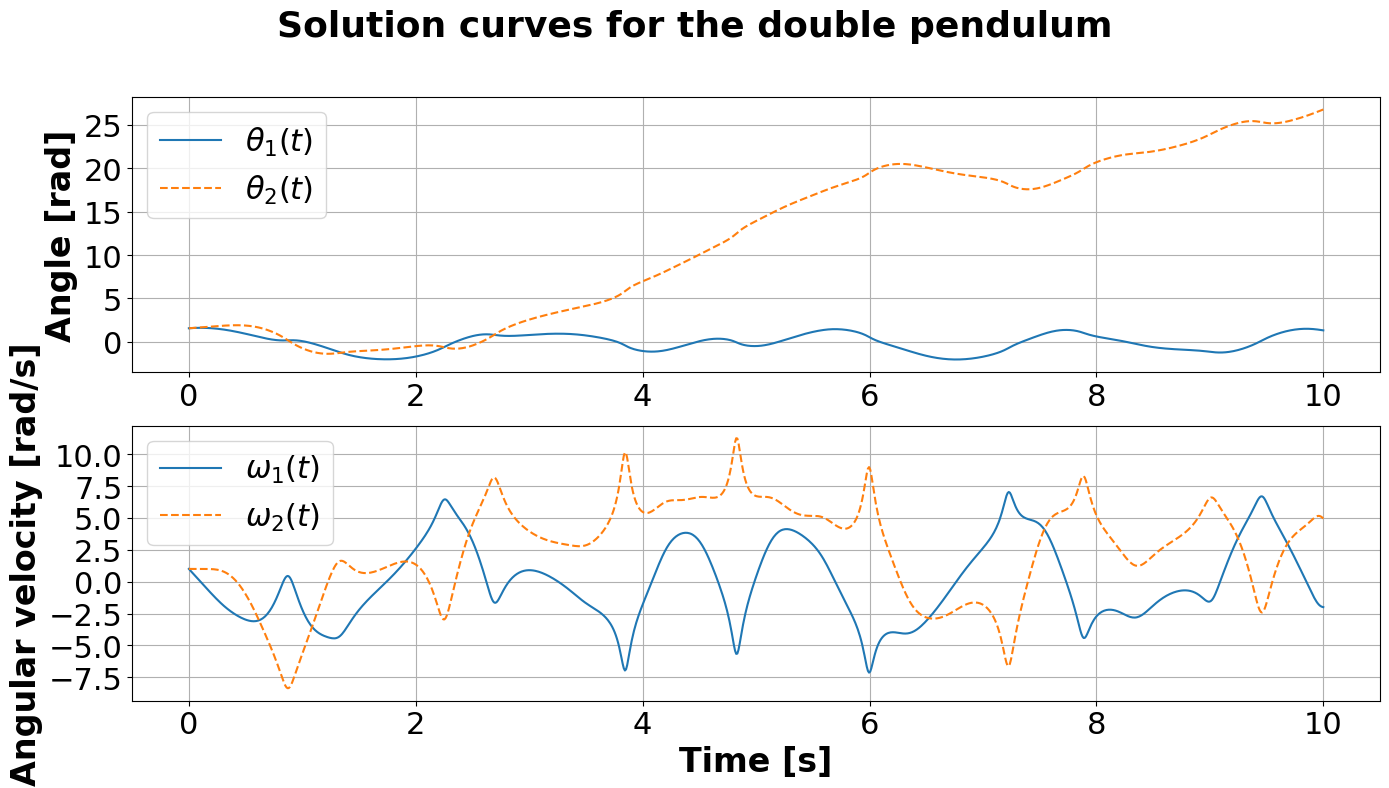

In [5]:


# ===================================== RUN CODE ==========================================

# Parameters
system_type = 'double' # System: 'simple', 'simple chaotic' or 'double'
angle_choice = 1 # Angle to use: 1 (θ₁) or 2 (θ₂)


# -------- Hyperparameters
N = 1000 # number of training sequences
window_size = 15
mean = 0
sigma = 1
epochs = 11
batch_size = 64

# ================ only for estimating analytical Lyapunov exponent ================
end = 50
T_max = 50          
num_points = 5000   
t = np.linspace(0, T_max, num_points)
#============================================================================

i0 = 0 # must be 0 for exact lyapunov prediction to make sense. Starting point after the trainig points.
k = 10
number_exponents = 20 # number of Lyapunov exponents to compute
hidden_dim = 32   # size of hidden state


# ============================= INSPECTION =====================================

plot_solution_curve() 
# plot_lyapunov_time(t, lp_network, 'Network FTLE') # estiamte LE of the physical system as a function of time

# ================================== TRAINING ==================================


X_train_all, y_train_all, X_pert_all = [], [], []
for init in initials:
    X, y, X_pert, *_ = get_data_full_state(init)
    X_train_all.append(X)
    y_train_all.append(y)
    X_pert_all.append(X_pert)

X_train = np.concatenate(X_train_all)
y_train = np.concatenate(y_train_all)
X_pert_train = np.concatenate(X_pert_all)


test_sets, X_test, y_test, X_pert_test = get_test_sets(initials) # use last one for testing --> scatter plot

model = model = define_model()
rnn_layer = model.layers[1]
tanh_prim = lambda x: 1 - np.tanh(x)**2
lyap_cb = LyapunovCallback(test_sets, k, number_exponents, N)

#results = train_model(lyap_cb)


In [108]:
# Load the data from epoch011
with open('models/simple_lyap_epoch011.pkl', 'rb') as f_011:
    simple_lyap_data_011 = pickle.load(f_011)

# Load the data from epoch020
with open('models/simple_lyap_epoch020.pkl', 'rb') as f_020:
    simple_lyap_data_020 = pickle.load(f_020)

# Load the data from epoch011
with open('models/sc_lyap_epoch011.pkl', 'rb') as f_011:
    sc_lyap_data_011 = pickle.load(f_011)

# Load the data from epoch020
with open('models/sc_lyap_epoch020.pkl', 'rb') as f_020:
    sc_lyap_data_020 = pickle.load(f_020)

# Load the data from epoch011
with open('models/double_lyap_epoch007.pkl', 'rb') as f_011:
    d_lyap_data_003 = pickle.load(f_011)

# Load the data from epoch020
with open('models/double_lyap_epoch023.pkl', 'rb') as f_020:
    d_lyap_data_020 = pickle.load(f_020)

In [115]:

simple_lyap_ple=np.multiply(np.concatenate((np.array(simple_lyap_data_011['lyap_list_all']),np.array(simple_lyap_data_020['lyap_list_all'])), axis=1),(k/2+N/2)*2/k)
simple_lyap_hsle=np.concatenate((np.array(simple_lyap_data_011['lyap_list_jac_all'][:6]),np.array(simple_lyap_data_020['lyap_list_jac_all'])), axis=1)

sc_lyap_ple=np.multiply(np.concatenate((np.array(sc_lyap_data_011['lyap_list_all']),np.array(sc_lyap_data_020['lyap_list_all'])), axis=1),(k/2+N/2)*2/k)
sc_lyap_hsle=np.concatenate((np.array(sc_lyap_data_011['lyap_list_jac_all'][:6]),np.array(sc_lyap_data_020['lyap_list_jac_all'])), axis=1)


In [116]:

d_lyap_ple=np.multiply(np.concatenate((np.array(d_lyap_data_003['lyap_list_all'][:3]),np.array(d_lyap_data_020['lyap_list_all'][:3])), axis=1),(k/2+N/2)*2/k)
d_lyap_hsle=np.concatenate((np.array(d_lyap_data_003['lyap_list_jac_all'][:3]),np.array(d_lyap_data_020['lyap_list_jac_all'][:3])), axis=1)

In [70]:
print(d_lyap_ple.shape)
print(d_lyap_hsle.shape)

(3, 20)
(3, 20)


In [111]:
import numpy as np
import csv

simple_train_loss = []
simple_val_loss = []
sc_train_loss = []
sc_val_loss = []
d_train_loss = []
d_val_loss = []

with open('models/simple_losses.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        simple_train_loss.append(float(row['train_loss']))
        simple_val_loss.append(float(row['val_loss']))
with open('models/simple_losses.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sc_train_loss.append(float(row['train_loss']))
        sc_val_loss.append(float(row['val_loss']))
with open('models/simple_losses.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        d_train_loss.append(float(row['train_loss']))
        d_val_loss.append(float(row['val_loss']))

# Convert lists to numpy arrays for all three cases
simple_train_loss = np.array(simple_train_loss)
simple_val_loss = np.array(simple_val_loss)
sc_train_loss = np.array(sc_train_loss)
sc_val_loss = np.array(sc_val_loss)
d_train_loss = np.array(d_train_loss)
d_val_loss = np.array(d_val_loss)


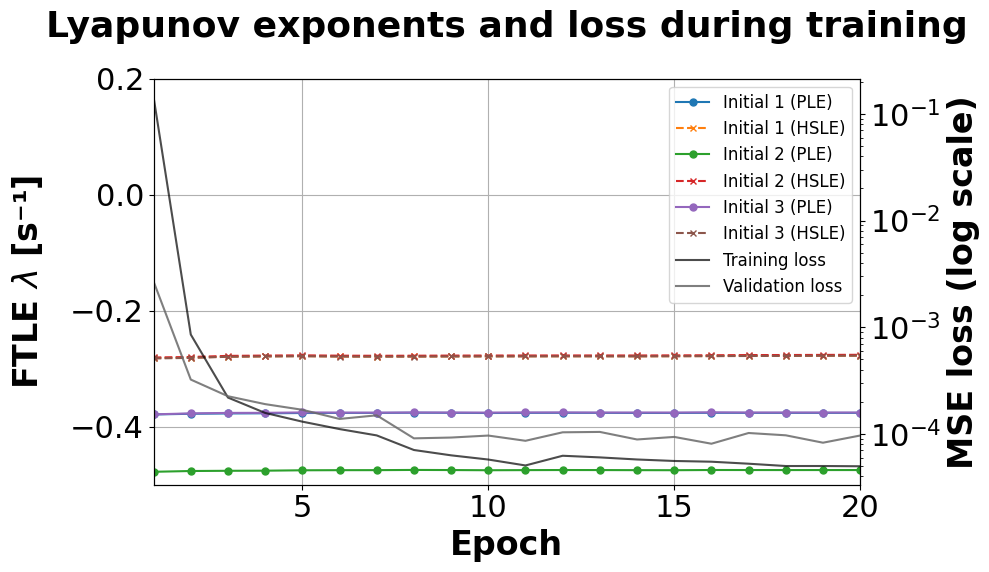

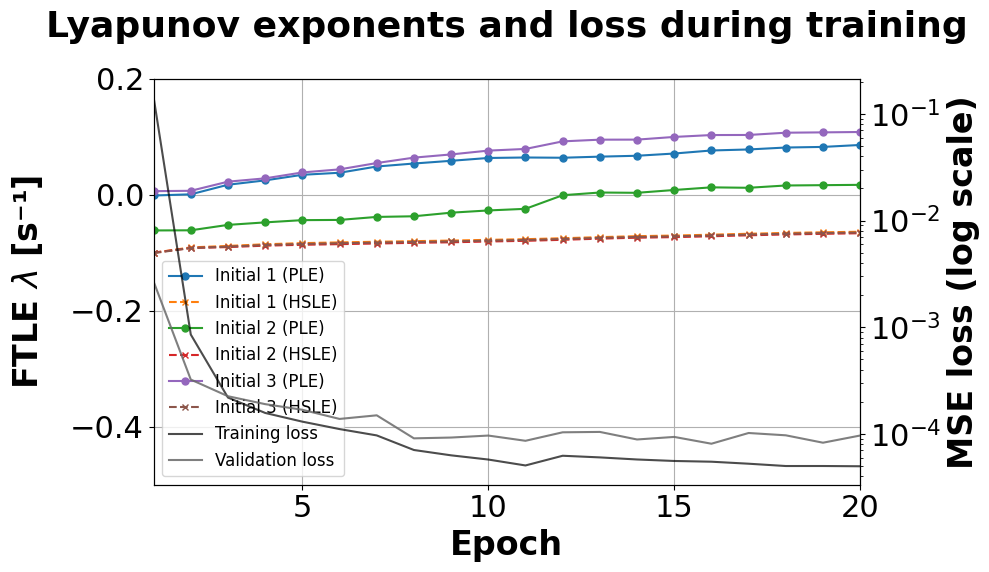

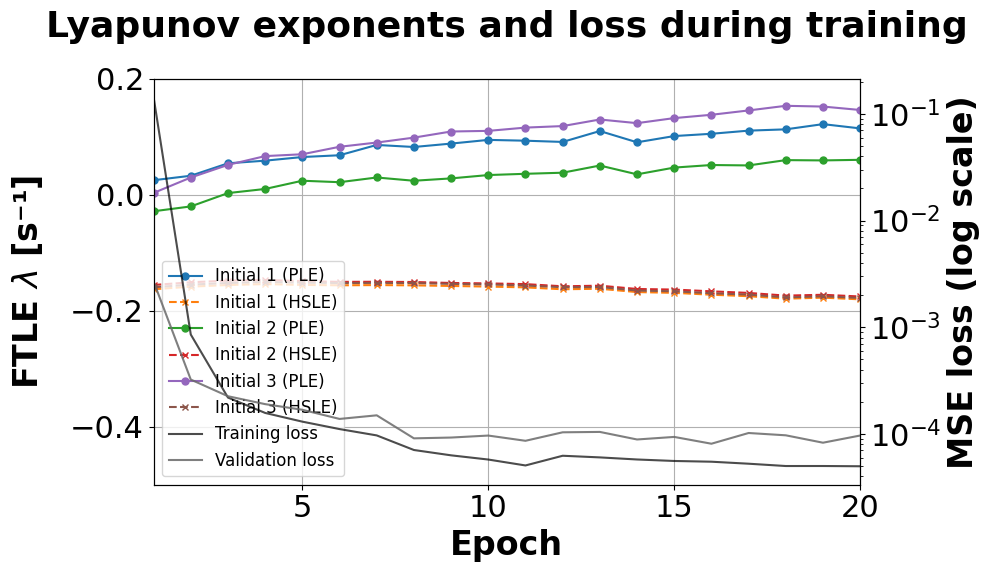

In [117]:

# =========================== POST TRAINING ===================================

labels = [f"Initial {i+1}" for i in range(len(initials))]

plot_lyapunov_comparison_all(simple_lyap_ple[:3], simple_lyap_hsle[:3], labels=labels[:3], train_loss=simple_train_loss, val_loss=simple_val_loss, legend_loc="upper right") # only plot first 3 initials
plot_lyapunov_comparison_all(sc_lyap_ple[:3], sc_lyap_hsle[:3], labels=labels[:3], train_loss=sc_train_loss, val_loss=sc_val_loss, legend_loc='lower left') # only plot first 3 initials
plot_lyapunov_comparison_all(d_lyap_ple[:3], d_lyap_hsle[:3], labels=labels[:3], train_loss=d_train_loss, val_loss=d_val_loss, legend_loc='lower left') # only plot first 3 initials
#scatter_plot_predictions(model, X_test, y_test)
#plot_predicted_vs_true_lyaps_dual(initials_lyaps, lyap_cb, labels) # For the last epoch LE estimate

# plot_lyapunov_noise(lyap_cb.lyap_list_jac_all,lyap_cb.lyap_list_jac_noise_all,labels)

# ==================================== END ====================================


In [102]:
simple_model = keras.models.load_model("models/double_model_epoch023.h5")

4/4 [==============================] - 0s 6ms/step


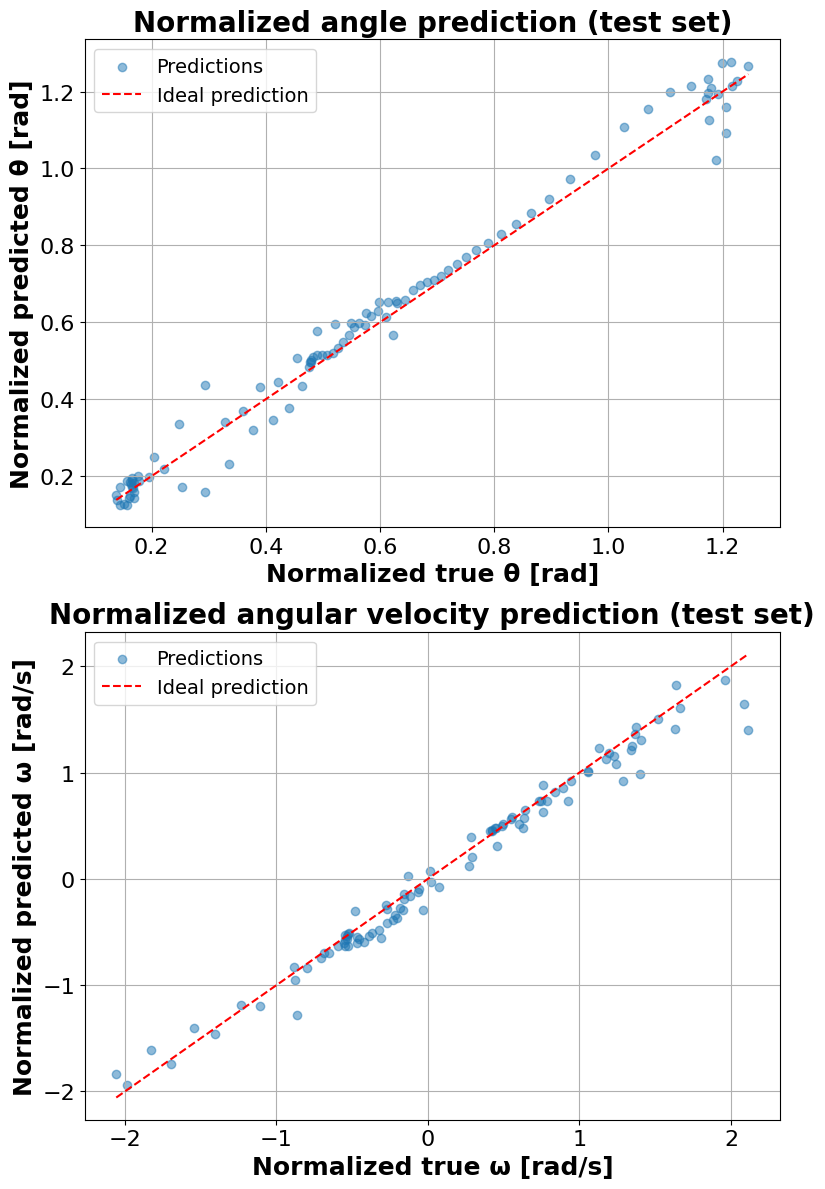

In [103]:
scatter_plot_predictions(simple_model, X_test, y_test)

In [6]:
def generate_LE_sets(initial, I, mean=0, sigma=1):
    system_type = 'double'
    angle_choice = 1
    t = np.linspace(0, I*50/1000, I)

    θ1, ω1, θ2, ω2 = solve_pendulum(t, initial)
    θ = θ1
    ω = ω1
    # Generate Gaussian noise for angle and angular velocity
    noise = np.random.normal(mean, sigma, size=len(t))

     # Perturbed versions
    θ_pert = θ + noise
    ω_pert = ω + noise

    # Normalize θ and ω separately using StandardScaler
    scaler_theta = StandardScaler()
    scaler_omega = StandardScaler()

    θ_scaled = scaler_theta.fit_transform(θ.reshape(-1, 1)).flatten()
    ω_scaled = scaler_omega.fit_transform(ω.reshape(-1, 1)).flatten()
    θ_pert_scaled = scaler_theta.transform(θ_pert.reshape(-1, 1)).flatten()
    ω_pert_scaled = scaler_omega.transform(ω_pert.reshape(-1, 1)).flatten()

    return np.transpose(np.array([θ_scaled, ω_scaled])), np.transpose(np.array([θ_pert_scaled, ω_pert_scaled])), noise, t

In [15]:
initial_conditions = [
    [np.pi/2, 1,       np.pi/2, 1],
    [np.pi/4, -1,      np.pi/4, -1],
    [-np.pi/2, 0,      np.pi/2, 0],
    [-np.pi, 0.5,      -np.pi/2, -0.5],
    [0.1, 2,           -3*np.pi/2, -1.5],
    [-np.pi, -2,       -np.pi/3, 1],
    [0.5, 1.5,         1, 0.5],
    [-0.7, -1.2,       2, -0.8],
    [np.pi/3, -np.pi/2, -np.pi, 1],
    [1.2, 0.4,         0.5, -2],
    [-1.5, 1.5,        1.5, -1.5],
    [np.pi, np.pi/4,   -1, 2],
    [-np.pi/3, -np.pi/4, 3, -2],
    [0.75, -1.75,      1.25, -0.5],
    [-2.5, 2,          -1.5, 0.5],
    [2.4, -0.9,        -2.4, 2.1],
    [1.8, -1.1,        0, 1.7],
    [0.9, -2.2,        1.1, -1.3],
    [-1.9, 1.8,        0.2, -2.2],
    [1.3, 0.3,         2.1, 0.1],
    [-np.pi/2, np.pi/2, -np.pi/2, np.pi/2],
    [0.25, -0.25,      0.75, -0.75],
    [-1.2, 2.2,        1.4, -1.9]
]

lyapunov_exponents = [
    1.40176,
    1.59057,
    2.28863,
    2.8809,
    2.7653,
    2.94079,
    0.95537,
    0.244256,
    3.27317,
    0.808105,
    1.71326,
    2.76014,
    1.40739,
    2.33086,
    2.18774,
    3.74851,
    1.84183,
    3.09968,
    3.74941,
    1.59696,
    1.5708,
    0.156456,
    3.14643
]

HSLEs = []
PLEs= []

model = keras.models.load_model("models/double_model_epoch023.h5")

I=1000
p=10
for initial in initial_conditions:
    print(f"Initial condition: {initial}")
    X_clean, X_pert, noise, t = generate_LE_sets(initial, I=I)
    x_noise = X_pert - X_clean # noise in phase space
    input_noise_norm = np.linalg.norm(x_noise) / I

    θ_clean_pred, ω_clean_pred = predict_k_steps(model, X_clean, k)
    θ_pert_pred, ω_pert_pred = predict_k_steps(model, X_pert, k)

    output_noise = np.stack([θ_pert_pred - θ_clean_pred, ω_pert_pred - ω_clean_pred], axis=1)
    output_noise_norm = np.linalg.norm(output_noise) / len(output_noise)

    lyap = lp_numeric(k, input_noise_norm, output_noise_norm, I)
    PLEs.append(lyap*(k/2+N/2)*2/k)


    # Jacobian method on a few
    H0 = np.zeros((1, hidden_dim))

    x_clean_batch = X_clean[np.newaxis, :, :] # add axis
    x_clean_batch_noise = x_noise[np.newaxis, :, :]
    

    lyap_jac = max(calc_LEs(x_clean_batch, H0, rnn_layer, tanh_prim, number_exponents)[0])
    # lyap_jac_noise = max(calc_LEs(x_clean_batch_noise, H0, rnn_layer, tanh_prim, self.number_exponents)[0])

    HSLEs.append(lyap_jac)

Initial condition: [1.5707963267948966, 1, 1.5707963267948966, 1]
Initial condition: [0.7853981633974483, -1, 0.7853981633974483, -1]
Initial condition: [-1.5707963267948966, 0, 1.5707963267948966, 0]
Initial condition: [-3.141592653589793, 0.5, -1.5707963267948966, -0.5]
Initial condition: [0.1, 2, -4.71238898038469, -1.5]
Initial condition: [-3.141592653589793, -2, -1.0471975511965976, 1]
Initial condition: [0.5, 1.5, 1, 0.5]
Initial condition: [-0.7, -1.2, 2, -0.8]
Initial condition: [1.0471975511965976, -1.5707963267948966, -3.141592653589793, 1]
Initial condition: [1.2, 0.4, 0.5, -2]
Initial condition: [-1.5, 1.5, 1.5, -1.5]
Initial condition: [3.141592653589793, 0.7853981633974483, -1, 2]
Initial condition: [-1.0471975511965976, -0.7853981633974483, 3, -2]
Initial condition: [0.75, -1.75, 1.25, -0.5]
Initial condition: [-2.5, 2, -1.5, 0.5]
Initial condition: [2.4, -0.9, -2.4, 2.1]
Initial condition: [1.8, -1.1, 0, 1.7]
Initial condition: [0.9, -2.2, 1.1, -1.3]
Initial condition: 

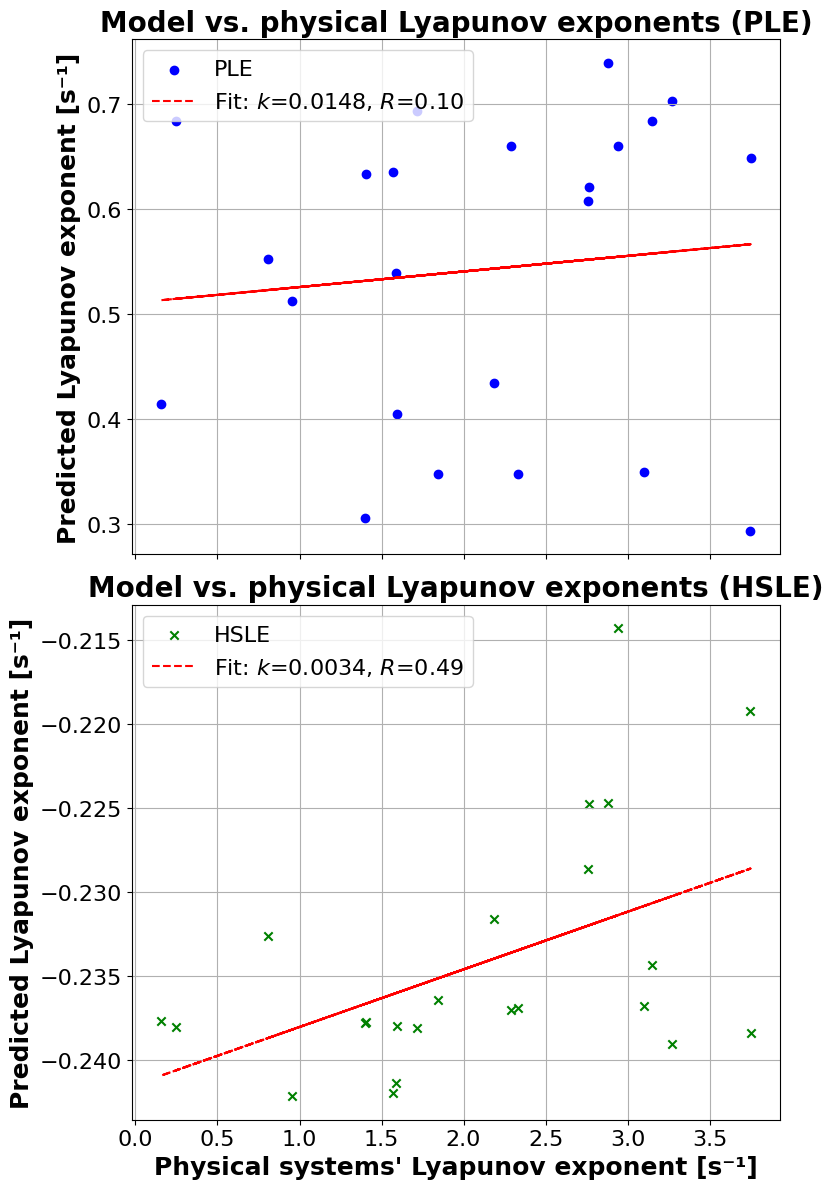

In [17]:
from scipy.stats import linregress

fig, axs = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# Top subplot: PLE
slope_ple, intercept_ple, r_value_ple, p_value_ple, std_err_ple = linregress(lyapunov_exponents, PLEs)
axs[0].scatter(lyapunov_exponents, PLEs, color='blue', marker='o', label='PLE')
axs[0].plot(lyapunov_exponents, slope_ple * np.array(lyapunov_exponents) + intercept_ple, color='red', linestyle='--', label=f'Fit: $k$={slope_ple:.4f}, $R$={r_value_ple:.2f}')
axs[0].set_ylabel('Predicted Lyapunov exponent [s⁻¹]', fontsize=18, fontweight='bold')
axs[0].set_title("Model vs. physical Lyapunov exponents (PLE)", fontsize=20, fontweight='bold')
axs[0].grid(True)
axs[0].legend(fontsize=16)
axs[0].tick_params(axis='both', labelsize=16)

# Bottom subplot: HSLE
slope_hsle, intercept_hsle, r_value_hsle, p_value_hsle, std_err_hsle = linregress(lyapunov_exponents, HSLEs)
axs[1].scatter(lyapunov_exponents, HSLEs, color='green', marker='x', label='HSLE')
axs[1].plot(lyapunov_exponents, slope_hsle * np.array(lyapunov_exponents) + intercept_hsle, color='red', linestyle='--', label=f'Fit: $k$={slope_hsle:.4f}, $R$={r_value_hsle:.2f}')
axs[1].set_xlabel("Physical systems' Lyapunov exponent [s⁻¹]", fontsize=18, fontweight='bold')
axs[1].set_ylabel('Predicted Lyapunov exponent [s⁻¹]', fontsize=18, fontweight='bold')
axs[1].set_title("Model vs. physical Lyapunov exponents (HSLE)", fontsize=20, fontweight='bold')
axs[1].grid(True)
axs[1].legend(fontsize=16)
axs[1].tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.show()
